In [87]:
# This script imports the NTSB training and validation sets,
# and iteratively tests the performance of various regression-based learners
# while grid searching over a range of hyperparameters for each, comparing
# the performance of all learners to each other and to a naive prediction
# which takes the mean value of each proprtion. After establishing the 
# best performing learner, feature importances are printed and the 
# model is applied to the test dataset.

# Load Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from xgboost import XGBRegressor



In [88]:

# Read in data, prepare for evaluation
## NOTE: The train/validation split has already been conducted at an earlier stage.

train = pd.read_csv('../data/ntsb_processed/ntsb_train_cleaned.csv').dropna()
validation = pd.read_csv('../data/ntsb_processed/ntsb_val_cleaned.csv').dropna()


In [89]:

target_f   = ['acft_prop_inj_f']
target_s   = ['acft_prop_inj_s']
features = ['latitude','longitude','apt_dist','gust_kts','altimeter','aircraft_count',
            'num_eng','days_since_insp','light_cond_DAYL','light_cond_DUSK','light_cond_NDRK',
            'light_cond_NITE','light_cond_other/unknown','BroadPhaseofFlight_Air',
            'BroadPhaseofFlight_Ground','BroadPhaseofFlight_Landing','BroadPhaseofFlight_Takeoff',
            'BroadPhaseofFlight_other/unknown','eng_type_REC','eng_type_TF','eng_type_TP','eng_type_TS',
            'eng_type_other/unknown','far_part_091','far_part_121','far_part_135','far_part_137','far_part_PUBU',
            'far_part_other/unknown','acft_make_beech','acft_make_bell','acft_make_boeing','acft_make_cessna',
            'acft_make_mooney','acft_make_other/unknown','acft_make_piper','acft_make_robinson helicopter',
            'acft_category_AIR','acft_category_HELI','acft_category_other/unknown','homebuilt_N','homebuilt_Y',
            'homebuilt_other/unknown','fixed_retractable_FIXD','fixed_retractable_RETR','fixed_retractable_other/unknown',
            'second_pilot_N','second_pilot_Y','second_pilot_other/unknown']

X_train = train[features]
y_train_f = np.ravel(train[target_f])
y_train_s = np.ravel(train[target_s])

X_val = validation[features]
y_val_f = np.ravel(validation[target_f])
y_val_s = np.ravel(validation[target_s])



In [90]:
# Initialize performance dataframe
performances = pd.DataFrame(columns=['learner','hyperparams','target',
                                     'train_mse','train_mae','val_mse','val_mae'])

# Initialize Grid Search & Performance Append Function
def fatal_grid_search(model, param_grid, label):
    "Iteratively runs grid search on specified parameter grid and appends performance info to master dataset."
    
    target='prop_inj_fatal' # Declares label for target variable in master dataset

    grid = GridSearchCV(
        model,
        param_grid,
        scoring='neg_mean_squared_error',
        cv=5
    )
    grid.fit(X_train,y_train_f)
    best_mod = grid.best_estimator_
    best_params = grid.best_params_

    # Train and validation prediction objects 
    y_train_pred = best_mod.predict(X_train)
    y_val_pred = best_mod.predict(X_val)

    # Performance metrics
    train_mse = mean_squared_error(y_train_f,y_train_pred)
    val_mse = mean_squared_error(y_val_f,y_val_pred)
    train_mae = mean_absolute_error(y_train_f, y_train_pred)
    val_mae = mean_absolute_error(y_val_f, y_val_pred)

    # Append to performance dataframe
    performances.loc[len(performances)] = [
        label,
        str(best_params),
        target,
        train_mse,
        train_mae,
        val_mse,
        val_mae
    ]
    
    return best_mod


In [91]:

############################################################
##             Modeling: FATAL INJURIES                   ##
############################################################
# Run iterative grid searches of hyperparameter values per model
# Save best performing model & its metrics

## Random Forest Regressor Grid Search
rf = RandomForestRegressor()
rf_param_grid = {
    'n_estimators':[10],
    'min_samples_leaf':[2],
    'max_samples':[100]
}
rf_mod_f = fatal_grid_search(rf,rf_param_grid,"randomforest")



In [92]:

## Histogram Gradient Boosting Regressor Search
histgrad = HistGradientBoostingRegressor()
hg_param_grid = {
    'learning_rate': [0.05,0.1],
    'max_iter': [100],
    'max_leaf_nodes': [3]
}
hg_mod_f = fatal_grid_search(histgrad, hg_param_grid, "histgrad")



## Extra Trees Regressor
extrees = ExtraTreesRegressor()
et_param_grid = {
    'max_depth': [2],
    'n_estimators': [10],
    'max_leaf_nodes': [3]
}
et_mod_f = fatal_grid_search(extrees,et_param_grid,"extrees")



## Bagging Regressor
baggingreg = BaggingRegressor()
bg_param_grid = {
    'n_estimators': [10],
}
bag_mod_f = fatal_grid_search(baggingreg,bg_param_grid,"bagging")


## XGBoost
xgb = XGBRegressor()
xgb_param_grid = {
    'n_estimators': [100],
    'max_depth': [3],
    'learning_rate': [0.1],
    'subsample': [0.6],
    'colsample_bytree': [0.6]
}
xgb_mod_f = fatal_grid_search(xgb,xgb_param_grid,"xgboost")

## "Naive" Prediction - Average Proportion of Fatal Injuries
naive_train_pred = [y_train_f.mean()] * len(y_train_f)
naive_val_pred = [y_train_f.mean()] * len(y_val_f)

train_mse = mean_squared_error(y_train_f,naive_train_pred)
val_mse = mean_squared_error(y_val_f, naive_val_pred)
train_mae = mean_absolute_error(y_train_f, naive_train_pred)
val_mae = mean_absolute_error(y_val_f, naive_val_pred)

performances.loc[len(performances)] = [
        'naivemean', '{n/a}', 'prop_inj_fatal',
        train_mse, train_mae,
        val_mse, val_mae]



In [93]:
performances

,learner,hyperparams,target,train_mse,train_mae,val_mse,val_mae
0,randomforest,"{'max_samples': 100, 'min_samples_leaf': 2, 'n...",prop_inj_fatal,0.115700,0.231996,0.108658,0.224463
1,histgrad,"{'learning_rate': 0.1, 'max_iter': 100, 'max_l...",prop_inj_fatal,0.102549,0.217220,0.096644,0.210467
2,extrees,"{'max_depth': 2, 'max_leaf_nodes': 3, 'n_estim...",prop_inj_fatal,0.112434,0.231645,0.105765,0.224322
3,bagging,{'n_estimators': 10},prop_inj_fatal,0.021018,0.079823,0.019736,0.076728
4,xgboost,"{'colsample_bytree': 0.6, 'learning_rate': 0.1...",prop_inj_fatal,0.096427,0.207897,0.091126,0.202111
5,naivemean,{n/a},prop_inj_fatal,0.121967,0.251053,0.114486,0.243489


In [ ]:

############################################################
# Initializing Serious Accidents Grid Search Function      #
############################################################


# Initialize Grid Search & Performance Append Function
def serious_grid_search(model, param_grid, label):
    "Iteratively runs grid search on specified parameter grid and appends performance info to master dataset."
    
    target='prop_inj_serious' # Declares label for target variable in master dataset

    grid = GridSearchCV(
        model,
        param_grid,
        scoring='neg_mean_squared_error',
        cv=5
    )
    grid.fit(X_train,y_train_s)
    best_mod = grid.best_estimator_
    best_params = grid.best_params_

    # Train and validation prediction objects 
    y_train_pred = best_mod.predict(X_train)
    y_val_pred = best_mod.predict(X_val)

    # Performance metrics
    train_mse = mean_squared_error(y_train_s,y_train_pred)
    val_mse = mean_squared_error(y_val_s,y_val_pred)
    train_mae = mean_absolute_error(y_train_s, y_train_pred)
    val_mae = mean_absolute_error(y_val_s, y_val_pred)

    # Append to performance dataframe
    performances.loc[len(performances)] = [
        label,
        str(best_params),
        target,
        train_mse,
        train_mae,
        val_mse,
        val_mae
    ]
    
    return best_mod



############################################################
##             Modeling: SERIOUS INJURIES                 ##
############################################################
# Run iterative grid searches of hyperparameter values per model
# Save best performing model & its metrics
# Since most objects for this script were created in previous section, all that must be done is to 
# run the new function on the same grid search & learner objects.

## Random Forest Regressor Grid Search
rf_mod_s = serious_grid_search(rf,rf_param_grid,"randomforest")

## Histogram Gradient Boosting Regressor Search
hg_mod_s = serious_grid_search(histgrad, hg_param_grid, "histgrad")

## Extra Trees Regressor
et_mod_s = serious_grid_search(extrees,et_param_grid,"extrees")

## Bagging Regressor
bag_mod_s = serious_grid_search(baggingreg,bg_param_grid,"bagging")

## XGBoost Regressor
xgb_mod_s = serious_grid_search(xgb,xgb_param_grid,"xgboost")

## "Naive" Prediction - Average Proportion of Serious Injuries
naive_train_pred = y_train_s.mean()
naive_val_pred = y_val_s.mean()

## "Naive" Prediction - Average Proportion of Serious Injuries
naive_train_pred = [y_train_s.mean()] * len(y_train_s)
naive_val_pred = [y_train_s.mean()] * len(y_val_s)

train_mse = mean_squared_error(y_train_s,naive_train_pred)
val_mse = mean_squared_error(y_val_s, naive_val_pred)
train_mae = mean_absolute_error(y_train_s, naive_train_pred)
val_mae = mean_absolute_error(y_val_s, naive_val_pred)

performances.loc[len(performances)] = [
        'naivemean', '{n/a}', 'prop_inj_serious',
        train_mse, train_mae,
        val_mse, val_mae]



############################################################
##             Model Comparison (w/ Naive Learner)        ##
############################################################

# In progress - need to build naive predictor and compare the results for both target variables.


NameError: name 'performancs' is not defined

In [95]:

performances

,learner,hyperparams,target,train_mse,train_mae,val_mse,val_mae
0,randomforest,"{'max_samples': 100, 'min_samples_leaf': 2, 'n...",prop_inj_fatal,0.115700,0.231996,0.108658,0.224463
1,histgrad,"{'learning_rate': 0.1, 'max_iter': 100, 'max_l...",prop_inj_fatal,0.102549,0.217220,0.096644,0.210467
2,extrees,"{'max_depth': 2, 'max_leaf_nodes': 3, 'n_estim...",prop_inj_fatal,0.112434,0.231645,0.105765,0.224322
3,bagging,{'n_estimators': 10},prop_inj_fatal,0.021018,0.079823,0.019736,0.076728
4,xgboost,"{'colsample_bytree': 0.6, 'learning_rate': 0.1...",prop_inj_fatal,0.096427,0.207897,0.091126,0.202111
5,naivemean,{n/a},prop_inj_fatal,0.121967,0.251053,0.114486,0.243489
6,randomforest,"{'max_samples': 100, 'min_samples_leaf': 2, 'n...",prop_inj_serious,0.081632,0.191419,0.080524,0.191902
7,histgrad,"{'learning_rate': 0.1, 'max_iter': 100, 'max_l...",prop_inj_serious,0.069857,0.159762,0.067631,0.158940
8,extrees,"{'max_depth': 2, 'max_leaf_nodes': 3, 'n_estim...",prop_inj_serious,0.072008,0.162523,0.070182,0.161592
9,bagging,{'n_estimators': 10},prop_inj_serious,0.014960,0.063172,0.014564,0.062684


/var/folders/c8/jr_n0v1x3n52_hpzs9nlqykw0000gn/T/ipykernel_93564/1266288448.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sort_values('score'))['learner']
/var/folders/c8/jr_n0v1x3n52_hpzs9nlqykw0000gn/T/ipykernel_93564/1266288448.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


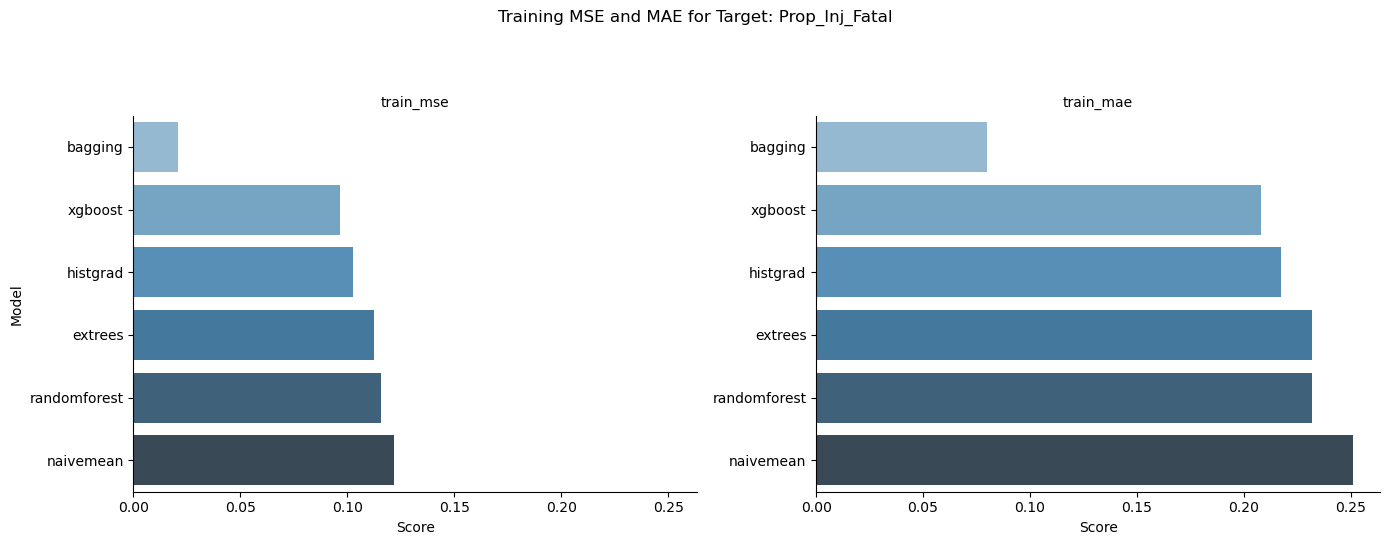

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Choose which target to plot
target_to_plot = 'prop_inj_fatal'  # or 'serious'

# 👇 2. Filter for that target only
df_filtered = performances[performances['target'] == target_to_plot].copy()

# 👇 3. Melt the dataframe to long format (only training metrics)
train_plot_df = df_filtered.melt(
    id_vars=['learner'],
    value_vars=['train_mse', 'train_mae'],
    var_name='metric',
    value_name='score'
)

# 👇 4. Sort learners within each metric by score
train_plot_df['learner'] = train_plot_df['learner'].astype(str)  # ensure it's sortable
sorted_order = (
    train_plot_df.groupby('metric')
    .apply(lambda x: x.sort_values('score'))['learner']
    .reset_index(drop=True)
    .drop_duplicates()
    .tolist()
)

# 👇 5. Create the horizontal bar plot with Seaborn
g = sns.catplot(
    data=train_plot_df,
    kind='bar',
    y='learner',
    x='score',
    col='metric',
    palette='Blues_d',
    height=5,
    aspect=1.4,
    sharey=False,
    order=sorted_order
)

g.set_titles("{col_name}")
g.set_axis_labels("Score", "Model")
g.fig.suptitle(f"Training MSE and MAE for Target: {target_to_plot.title()}", y=1.08)

plt.tight_layout()
plt.show()
